<a href="https://colab.research.google.com/github/daviethedeveloper/TensorFlowNotes/blob/main/04_Transfer_Learning_Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow *Feature Etraction*

Transfer Learning is leveraging a working's model's existing architecture and learned patterns.

Main Benefits:
1. Can leverage an existing neural network architecture proven to work on similar problems
2. Can leverage a working neural network architecture which has learned similar patterns on simliar data, then an able to adapt, adapt those patterns to our own data


In [ ]:
# Are we using a GPU??
!nvidia-smi

Mon Jul 10 18:32:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Download and Understand the Data

In [ ]:
# Get only 10 percent of the data from the food clases
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-07-10 20:06:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 108.177.12.128, 108.177.13.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   162MB/s    in 1.0s    

2023-07-10 20:06:32 (162 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each foler
import os

# Walk through the directory
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/train
There are 0 directories and 75 images in 10_food_classes_10_percent/train/fried_rice
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_curry
There are 0 directories and 75 images in 10_food_classes_10_percent/train/grilled_salmon
There are 0 directories and 75 images in 10_food_classes_10_percent/train/sushi
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ramen
There are 0 directories and 75 images in 10_food_classes_10_percent/train/steak
There are 0 directories and 75 images in 10_food_classes_10_percent/train/pizza
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_wings
There are 0 directories and 75 images in 10_food_classes_10_percent/train/hamburger
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ice_cream
There are 10 director

## Creating data loaders  (preparring the data)
Use the `ImageDataGenerator` class to load the images

In [ ]:
# Setup the data Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"


train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)


print("Training Images: ")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SIZE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing Images: ")
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                        target_size=IMAGE_SIZE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode="categorical")

Training Images: 
Found 750 images belonging to 10 classes.
Testing Images: 
Found 2500 images belonging to 10 classes.


## Setting Up Callbacks
(Run while the model trains)
> Callbacks are extra functinality you can add to the models to be performed during or after training.

* Tracking experiments with the TensorBoard Callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits)



In [ ]:
# Create a folder on name of experiment
# Create a TensorBoard callback (functionized)

import datetime # when the model was run

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Creating models using Tensorflow Hub

Used TensorFlow to create our own models layer by layer from scratch.

Now goign to use a similar process, but the majority of the models will come from TensorFlow Hub

> https://paperswithcode.com/sota


Browsing the TensorFlow Hub page and sorting for image classificaition, found a feature model link.


In [ ]:
# Compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Let's make a create_model() function from the url
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
            should be equal to number of target classes, default 10.
    Returns:
      An uncompile Keras Sequential model with model_url as feature extractor
      layer and Dense output layer with num_classes output neurons.
  """

  # Download the pretrained model and save it as a keras layers
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extractor_layer",
                                           input_shape=IMAGE_SIZE+(3, ))

  # Create the Sequential Model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

In [ ]:
# Create a function to plot loss curves
# Function in a script called helper.py and import it when needed
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns seprate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object

  Returns:
    Plots of training/validation loss of accuracy

  Note: Only using accuracy as a metrics will work
  """

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot Loss
  plt.plot(epochs, loss, label="training_los")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend();

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="trainig_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

### Creating ResNet TensorFlow Hub feature Extraction model

In [ ]:
# Create ResNet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 2048)             23564800  
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# Compile the model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
# Fit the model with epochs 5 ( 10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data_10_percent,
                                  validation_steps=len(test_data_10_percent),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20230710-201701
Epoch 1/5
24/24 [==============================] - 33s 851ms/step - loss: 1.9616 - accuracy: 0.3467 - val_loss: 1.2044 - val_accuracy: 0.6148
Epoch 2/5
24/24 [==============================] - 18s 789ms/step - loss: 0.8965 - accuracy: 0.7373 - val_loss: 0.8209 - val_accuracy: 0.7448
Epoch 3/5
24/24 [==============================] - 18s 758ms/step - loss: 0.6111 - accuracy: 0.8253 - val_loss: 0.7481 - val_accuracy: 0.7640
Epoch 4/5
24/24 [==============================] - 18s 783ms/step - loss: 0.4662 - accuracy: 0.8893 - val_loss: 0.6994 - val_accuracy: 0.7768
Epoch 5/5
24/24 [==============================] - 18s 760ms/step - loss: 0.3682 - accuracy: 0.9200 - val_loss: 0.6519 - val_accuracy: 0.7836


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 2048)             23564800  
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


>**NOTE**
Transfer leaening freature extraction imported ResNet50* use that archicture, trained the dense layer on the end custom class of 10.
>**NOTE**
This out performed ALL of the previous models I have built in less times AND only 10 percent of the training examples

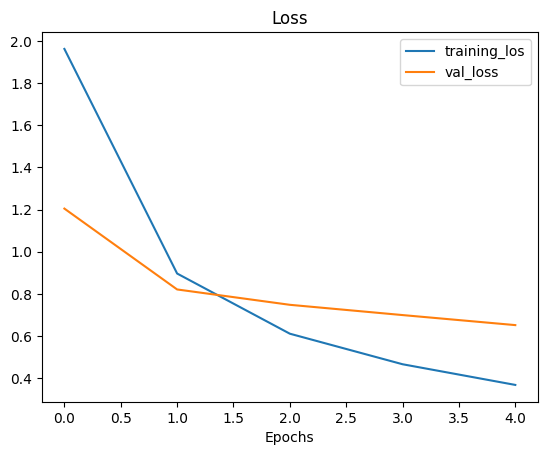

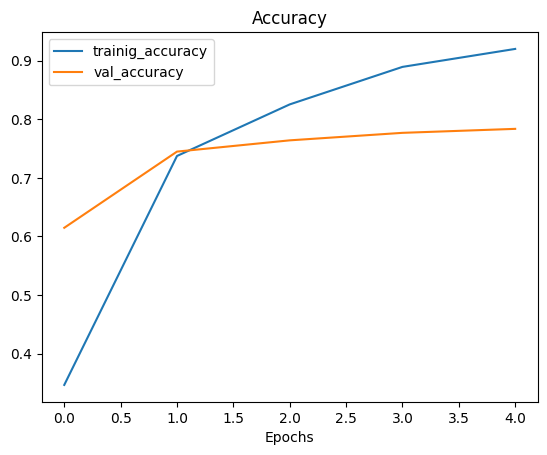

In [ ]:
plot_loss_curves(resnet_history)

### Creating and Testing EfficientNetB0 TensorFlow Hub feature Extraction model

In [ ]:
# Create the EfficientNetB0 model
efficient_net = create_model(efficientnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [ ]:
# Compile the model to fit
efficient_net.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
# Fit the model with epochs 5 ( 10 percent of 10 classes)
efficient_history = efficient_net.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data_10_percent,
                                  validation_steps=len(test_data_10_percent),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="EfficientNetB0")])

Saving TensorBoard log files to: tensorflow_hub/EfficientNetB0/20230710-205349
Epoch 1/5
24/24 [==============================] - 59s 2s/step - loss: 1.9264 - accuracy: 0.3867 - val_loss: 1.3425 - val_accuracy: 0.7324
Epoch 2/5
24/24 [==============================] - 19s 823ms/step - loss: 1.0942 - accuracy: 0.7667 - val_loss: 0.8907 - val_accuracy: 0.8196
Epoch 3/5
24/24 [==============================] - 18s 765ms/step - loss: 0.7735 - accuracy: 0.8293 - val_loss: 0.7081 - val_accuracy: 0.8440
Epoch 4/5
24/24 [==============================] - 18s 774ms/step - loss: 0.6184 - accuracy: 0.8600 - val_loss: 0.6177 - val_accuracy: 0.8548
Epoch 5/5
24/24 [==============================] - 23s 983ms/step - loss: 0.5207 - accuracy: 0.8747 - val_loss: 0.5609 - val_accuracy: 0.8620


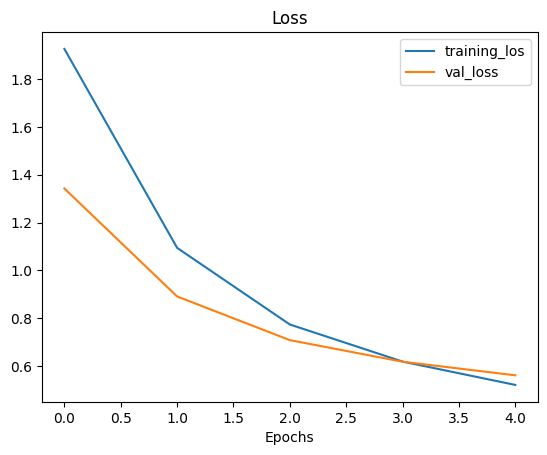

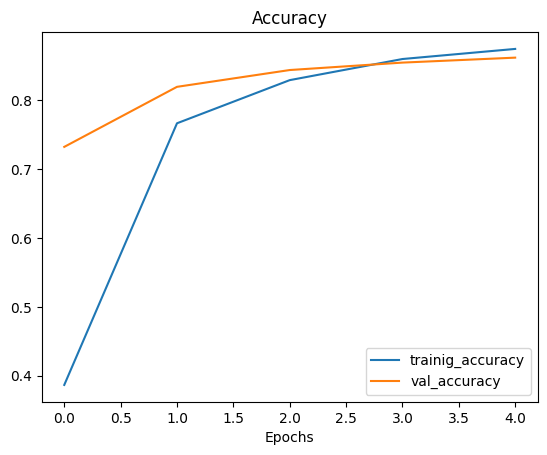

In [ ]:
plot_loss_curves(history=efficient_history)

### Comparing Models

EfficientNet Model vs. ResNet Model

In [ ]:
efficient_net.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 1280)             4049564   
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 2048)             23564800  
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# See the aproximant layers on each model
efficient_layer_len = len(efficient_net.layers[0].weights)

resnet_layer_len = len(resnet_model.layers[0].weights)
efficient_layer_len, resnet_layer_len

(309, 270)

## Different types of transfer learning

* **"As is"** transfer learning - using an existing model with no changes added/suplemented
* **"Feature extraction"** transfer learning - use the prelearned patterns of an existing model (adjust the output layer Dense Layer 10 classes)
* **"Fine-tuning"** transfer learning - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

## Comparing Model's Results

> **Note:** When you upload things to TensorBoard.dev, the experiments are public. So if running private things, don't want others to see, don't publish to TensorBoard (public)

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
 --name "EddicientNetB0 vs. ResNet50V2" \
 --description "Comparing two different TF Hub feature extraction model architectures" \
 --one_shot

2023-07-10 21:40:22.525399: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   BJNR-VPTH



New experiment created. View your TensorBoard at: https://tensorboard.dev/expe

TensorBoard experiments are uploaded publically here: https://tensorboard.dev/experiment/qWBm9njXQ6GqLTdaZmkAxw/